In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 2*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-04-03 09:31:22.844672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 09:31:22.943343: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 09:31:23.352858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-03 09:31:23.352920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-03 09:31:24.070393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 09:31:24.070608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 09:31:24.070751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 09:31:24.404839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 09:31:24.405014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [219]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
idx = 500 
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

#remove NaNs
# pc1[pc1[:,0]>64] = 100
# pc1[pc1[:,0]<-64] = 100
# pc1 = np.nan_to_num(pc1, nan=0.0)

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

512.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image

(64, 1024)


<IPython.core.display.Javascript object>


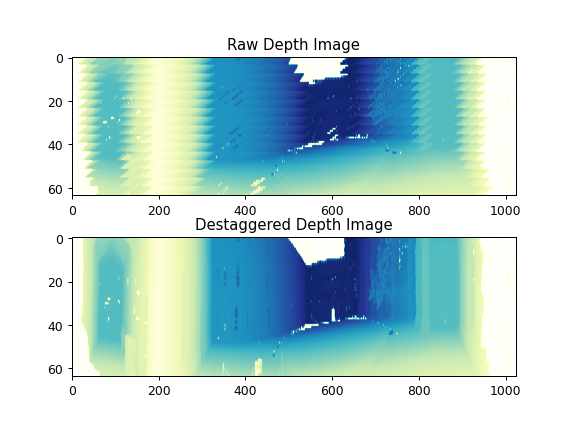

(64, 1024)


In [222]:
%matplotlib notebook
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
pcs = np.reshape(pc1_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)
raw_data = pcs[:,:,0].T

# print(np.shape(data))

data = np.zeros([64, 1024])
for i in range(np.shape(data)[0]//4):
    #shift left
#     data[4*i,:-18] = raw_data[4*i,18:]
#     data[4*i+1,:-12] = raw_data[4*i+1,12:]
#     data[4*i+2,:-6] = raw_data[4*i+2,6:]
#     data[4*i+3,:] = raw_data[4*i+3,:]
#     #shift right
#     data[4*i,:] = raw_data[4*i,:]
#     data[4*i+1,6:] = raw_data[4*i+1,:-6]
#     data[4*i+2,12:] = raw_data[4*i+2,:-12]
#     data[4*i+3,18:] = raw_data[4*i+3,:-18]
    #keep centered-- avoids needing to fill in gaps
#     data[4*i,:-9] = raw_data[4*i,9:]
#     data[4*i+1,:-3] = raw_data[4*i+1,3:]
#     data[4*i+2,3:] = raw_data[4*i+2,:-3]
#     data[4*i+3,9:] = raw_data[4*i+3,:-9]
    data[4*i,1:-8] = raw_data[4*i,9:]
    data[4*i+1,1:-2] = raw_data[4*i+1,3:]
    data[4*i+2,4:] = raw_data[4*i+2,:-4]
    data[4*i+3,10:] = raw_data[4*i+3,:-10]

fig, ax = p.subplots(2,1)
ax[0].set_title("Raw Depth Image")
ax[0].imshow(raw_data, cmap = "YlGnBu", norm='log')
ax[0].set_aspect(5)
ax[1].set_title("Destaggered Depth Image")
ax[1].imshow(data, cmap = "YlGnBu", norm='log')
ax[1].set_aspect(5)
print(np.shape(data))


# Reproject 2D Depth image back to 3D point cloud

#### IMPORTANT: look into pixel_shift_by_row parameter from OUSTER
https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts

In [218]:
#OS1 LiDAR Intrinsics
#as specified in datasheet
# phimin = np.deg2rad(-16.6) #supposed to be this
# phimax = np.deg2rad(16.6)
#angles required to reproduce observed point clouds
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
depth_img  = data.T

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(depth_img)[0]):
    for h in range(np.shape(depth_img)[1]):
        new_point_cloud_spherical[count,0] = depth_img[w,h] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(depth_img)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth_img)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
# print(vert_fov)
# vert_fov/360
# print((vert_fov/360)*np.shape(pcs)[0])

IndexError: index 4096 is out of bounds for axis 0 with size 4096

In [204]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

color = 255*np.linspace(0,1,len(new_point_cloud_cart)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(new_point_cloud_cart, c=cname,  r = 3.5, alpha =0.5))
# disp.append(Points(new_point_cloud_cart[::32], c='red',  r = 3.5, alpha =0.8))
# disp.append(Points(new_point_cloud_cart[::4], c='blue',  r = 5., alpha =0.125))

disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Load ground truth poses (map frame) and convert to NeRF LH Coordinate System

In [205]:
from os import listdir

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(np.shape(gt))
# print(gt[20,:])

scan_dir = dir_name + experiment_name + "raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/"
list_of_all_scans = sorted(listdir(scan_dir))

# #plot ground truth trajectory
# fig, ax = p.subplots()
# ax.set_aspect('equal')
# ax.set_xlabel("x (m)")
# ax.set_ylabel("y (m)")
# ax.plot(gt[:,2], gt[:,3], label = "ground truth")

# #superimpose trajectory from <short_experiment_01>
# first_timestamp = int(list_of_all_scans[0][6:16])
# last_timestamp = int(list_of_all_scans[-1][6:16]) #scrape timestamp from name of velodyne .pcl file

# first_idx = np.argwhere(gt[:,0] == first_timestamp)[0][0]
# last_idx = np.argwhere(gt[:,0] == last_timestamp)[0][0]
# # print(last_idx)
# ax.plot(gt[first_idx:last_idx,2], gt[first_idx:last_idx,3], 'r', lw = 10, alpha = 0.3, label = 'area covered by lidar data')
# ax.legend(loc = 'best')

In [410]:
from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images =  20 
n_rots = 2 #8 

phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots,4,4])
images = np.ones([n_images*n_rots, 64, 64, 2]) #depth image and raydrop

for i in range(n_images):
    #load point cloud
    idx = i*20 + 650    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
#     pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention
    pc1 = np.flip(pc1, axis = 1)#test
    #convert to depth image
    pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
#     raw_data = pcs[:,:,0].T #TODO: issue here
    raw_data = pcs[:,:,:] #TODO: issue here
    raw_data = np.transpose(pcs, [1,0,2])
#     print(np.shape(raw_data))
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    
#     fig, ax = p.subplots()
#     ax.imshow(data)
    
    for j in range(n_rots):
        
        #get cropped depth image ~~~~~~~~~~~~~~~~~~~~
        pcs = np.flip(data, axis = 1) #flip vertical
        pcs = np.flip(pcs, axis = 0) #flip horizontal to look at first clockwise patch of scan sweep 
        pcs = pcs.T
#         print(np.shape(pcs))
#         pcs = np.reshape(pc1_spherical, [-1,64,3]) #Test
#         print(np.shape(pcs))
#         fig, ax = p.subplots()
#         ax.imshow(pcs)
        
        #resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0])        
        pcs = pcs[j*image_width:(j+1)*image_width,:].T #SQUARE
#         pcs = pcs[(j+1)*image_width:(j+2)*image_width,:].T #SQUARE-- skip beginning of frame (blocked by human)
#         pcs = pcs[(j*image_width//32):((j+1)*image_width//32),:,0].T #32nds
        pcs = cv2.resize(pcs, (64, 64), cv2.INTER_NEAREST) #keep square

        #preserve aspect ratio and focal length but just take middle
#         pcs = pcs[:,31:33] #uncomment for 32nds
        images[j+(i*n_rots),:,:,0] = pcs #save depth information to first channel
        a = np.argwhere(pcs > 64)
#         non_returns[j+(i*n_rots),a[:,0],a[:,1],0] = 1
        images[j+(i*n_rots),a[:,0],a[:,1],1] = 0 #save raydrop mask to 2nd channel
        
        
        #get transformation matrix ~~~~~~~~~~~~~~~~~~
        rotm = np.eye(4)
        rotm[0,3] = gt[idx,2] #x
        rotm[2,3] = -gt[idx,3] #y
        rotm[1,3] = -gt[idx,4] #z
        rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 
#         rotm[:3,:3] = np.linalg.pinv(rotm[:3,:3]) #TEST
        
        #account for image crop in rotation
        crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin) #square
        #         crop_angle = -(phimax-phimin)/64 - j*(phimax-phimin)/32 #2-pixels wide
        rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #correct
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

        #flip x and z axis
        rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

#         # flip sign of y and z axis
        rotm[0:3,2] *= -1 
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:] #was this
#         rotm = rotm[[2,1,0,3],:]
        rotm[2,:] *= -1 # flip whole world upside down
        #translate all frames above xy plane
        rotm[2,-1] += 0 
        
        poses[j+(i*n_rots)] = rotm

In [411]:
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# new_point_cloud_spherical = np.zeros([np.shape(images)[1]*np.shape(images)[2],3])

for i in range(n_images*n_rots):
    #convert depth image back to point cloud
    count = 0
    for w in range(np.shape(images)[1]):
        for h in range(np.shape(images)[2]):
            new_point_cloud_spherical[count,0] = images[i,w,h,0] #radius
            new_point_cloud_spherical[count,1] = -(phimax-phimin)*(w/np.shape(images)[1]) #theta
#             new_point_cloud_spherical[count,1] = -(phimax-phimin)*(w/np.shape(images)[1])
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2]) #phi
#             new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2])/8 
#             new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2])/16 
#             new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2])/32 
            count+= 1
            
    #transform each to base frame using <poses>
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z -- does this indicate an error somewhere???
    disp.append(Points(new_point_cloud_cart, c='red',  r = 3.5, alpha =0.5))
    
#     #debug: draw origonal point cloud from scan i in blue ~~~~~~~~~
#     pcfn = "gazebo_scene2/scan" + str(i+2) + ".npy" #box
#     pc = np.load(pcfn)
#     disp.append(Points(pc, c = 'blue' ,r = 3.5, alpha=0.5))
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames for each sub-scan 
    #forward view direction (-z in NeRF c2w convention)
    headings = poses[i,:3,:3] @ np.array([0,0,-1])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "yellow"))
    # x
    headings = poses[i,:3,:3] @ np.array([1,0,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "red"))
    #y
    headings = poses[i,:3,:3] @ np.array([0,1,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "green"))
    #z
    headings = poses[i,:3,:3] @ np.array([0,0,1])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "blue"))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1920)

# Debug: draw frames

<IPython.core.display.Javascript object>


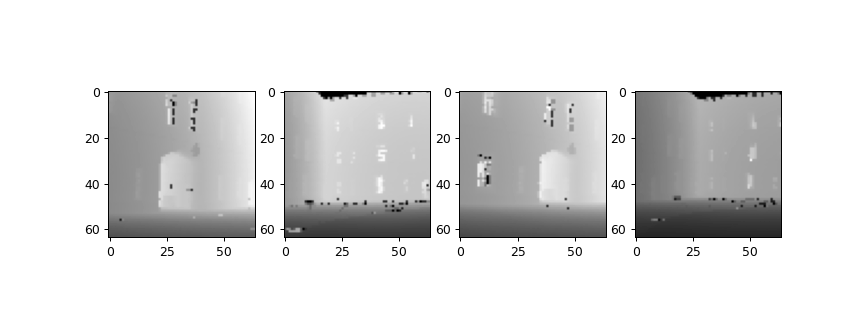

In [364]:
fig, ax = p.subplots(1,4)
ax[0].imshow(images[0,:,:,0], cmap = "gray", norm='linear')
ax[1].imshow(images[1,:,:,0], cmap = "gray", norm='linear')
ax[2].imshow(images[2,:,:,0], cmap = "gray", norm='linear')
ax[3].imshow(images[3,:,:,0], cmap = "gray", norm='linear')


<IPython.core.display.Javascript object>


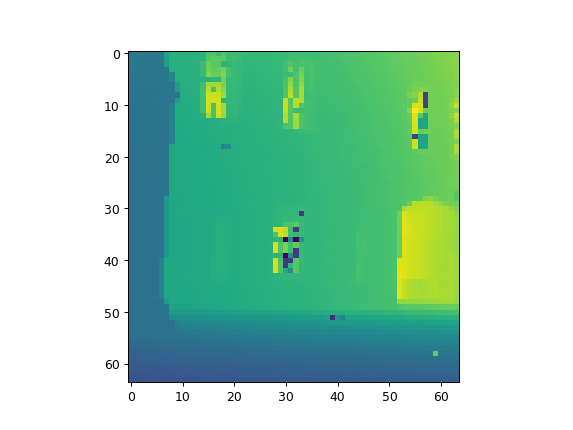

[[36 30]
 [36 32]
 [39 30]]


In [409]:
test = images[5,:,:,0]
fig, ax = p.subplots()
ax.imshow(test)

z = np.argwhere(test == 0)
print(z)